In [70]:
import numpy as np
import random
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold, validation_curve
from sklearn import metrics
from timeit import default_timer as timer

In [71]:
games = pd.read_csv('games.csv')
ranking = pd.read_csv('ranking.csv')
teams = pd.read_csv('teams.csv')

In [72]:
# Length of NBA games dataset
print(len(games))

24195


# Data Collection and Data Cleaning

In [73]:
games.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  ...  AST_away  REB_away  HOME_TEAM_WINS
0    2021-03-21  22000645            Final  ...      27.0      50.0               0
1    2021-03-21  22000016            Final  ...      22.0      52.0               0
2    2021-03-21  22000646            Final  ...      26.0      45.0               0
3    2021-03-21  22000167            Final  ...      20.0      44.0               1
4    2021-03-21  22000647            Final  ...      24.0      43.0               1

[5 rows x 21 columns]

In [74]:
teams.head()

LEAGUE_ID     TEAM_ID  ...      HEADCOACH  DLEAGUEAFFILIATION
0          0  1610612737  ...   Lloyd Pierce       Erie Bayhawks
1          0  1610612738  ...   Brad Stevens     Maine Red Claws
2          0  1610612740  ...   Alvin Gentry        No Affiliate
3          0  1610612741  ...     Jim Boylen    Windy City Bulls
4          0  1610612742  ...  Rick Carlisle       Texas Legends

[5 rows x 14 columns]

In [75]:
ranking.head()

TEAM_ID  LEAGUE_ID  SEASON_ID  ... HOME_RECORD ROAD_RECORD RETURNTOPLAY
0  1610612762          0      22020  ...        16-2        14-9          NaN
1  1610612756          0      22020  ...        15-8        13-5          NaN
2  1610612747          0      22020  ...        14-9        14-6          NaN
3  1610612746          0      22020  ...        14-6       13-10          NaN
4  1610612743          0      22020  ...        12-9        13-8          NaN

[5 rows x 13 columns]

In [76]:
games['home_team_abv'] = games.HOME_TEAM_ID.map(teams.set_index('TEAM_ID')['ABBREVIATION'].to_dict())
games['home_team_nick'] = games.HOME_TEAM_ID.map(teams.set_index('TEAM_ID')['NICKNAME'].to_dict())

In [77]:
games['vis_team_abv'] = games.VISITOR_TEAM_ID.map(teams.set_index('TEAM_ID')['ABBREVIATION'].to_dict())
games['vis_team_nick'] = games.VISITOR_TEAM_ID.map(teams.set_index('TEAM_ID')['NICKNAME'].to_dict())

In [78]:
games['home_w_pct'] = games.HOME_TEAM_ID.map(ranking.set_index('TEAM_ID')['W_PCT'].to_dict())

In [79]:
games['vis_w_pct'] = games.VISITOR_TEAM_ID.map(ranking.set_index('TEAM_ID')['W_PCT'].to_dict())

In [80]:
games = games.iloc[::-1].reset_index(drop=True) # Reverse dataframe from oldest to most recent
games.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  ...  vis_team_nick  home_w_pct  vis_w_pct
0    2014-10-04  11400001            Final  ...       Pelicans       0.659      0.573
1    2014-10-05  11400002            Final  ...          Kings       0.585      0.341
2    2014-10-06  11400005            Final  ...        Nuggets       0.329      0.439
3    2014-10-06  11400004            Final  ...        Wizards       0.585      0.537
4    2014-10-06  11400007            Final  ...       Pelicans       0.463      0.573

[5 rows x 27 columns]

In [81]:
# Spread = Points Home - Points Away
games['spread'] = games['PTS_home'] - games['PTS_away']
games.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS', 'home_team_abv', 'home_team_nick',
       'vis_team_abv', 'vis_team_nick', 'home_w_pct', 'vis_w_pct', 'spread'],
      dtype='object')

In [82]:
team_abvs = teams["ABBREVIATION"]
years = games["GAME_DATE_EST"].str.split("-").str[0].unique()
years.sort()

# Models

## Spread Model

In [83]:
x_train = games[[ 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 
                 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']].astype('float')
y_train = games["spread"].astype('float')

In [84]:
 # Removing rows that contain NaN values
x_train = x_train.fillna(0).values
y_train = y_train.fillna(0).values

In [85]:
# Negative spread = Away has an advantage | Positive spread = Home has an adventage
# Predicting spread
ridge_model_spread = Pipeline([('scaler', StandardScaler()), 
                      ('Ridge', Ridge(alpha=1, fit_intercept=True))])

ridge_model_spread = ridge_model_spread.fit(x_train, y_train)
y_pred = ridge_model_spread.predict(x_train)

games["pred_spread"] = np.zeros(len(games["spread"]))
games["pred_spread"] = y_pred
games.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  ...  vis_w_pct  spread  pred_spread
0    2014-10-04  11400001            Final  ...      0.573   -12.0    -4.365211
1    2014-10-05  11400002            Final  ...      0.341     5.0    -5.902613
2    2014-10-06  11400005            Final  ...      0.439     3.0    11.273304
3    2014-10-06  11400004            Final  ...      0.537    -4.0    -4.584248
4    2014-10-06  11400007            Final  ...      0.573     6.0    14.047221

[5 rows x 29 columns]

In [86]:
ridge_model_spread_error = metrics.mean_squared_error(y_train, y_pred)
ridge_model_spread_error

47.61443231210711

Text(0, 0.5, 'Error')

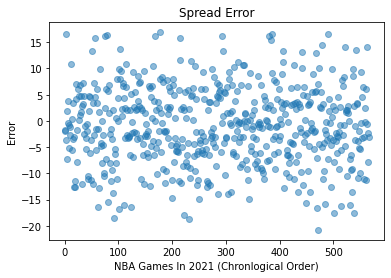

In [87]:
games_2021 = games[games["GAME_DATE_EST"].str.contains("2021")]
x = range(len(games_2021))
y1 = games_2021["spread"] - games_2021["pred_spread"]

plt.scatter(x, y1, alpha=0.5)
plt.title("Spread Error")
plt.xlabel("NBA Games In 2021 (Chronlogical Order)")
plt.ylabel("Error")

Text(0, 0.5, 'Probability')

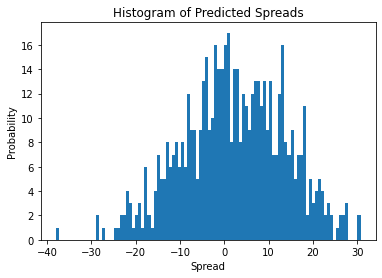

In [88]:
plt.hist(games_2021["pred_spread"], bins=100)
plt.title("Histogram of Predicted Spreads")
plt.xlabel("Spread")
plt.ylabel("Probability")
# The spread in the dataset has a maximum of 16

In [89]:


# Average and SD of the spread
avg_spread = np.mean(games["pred_spread"])
sd_spread = np.std(games["pred_spread"])
avg_spread, sd_spread

(2.8824963835503072, 11.387127490960632)

Text(0, 0.5, 'Probability')

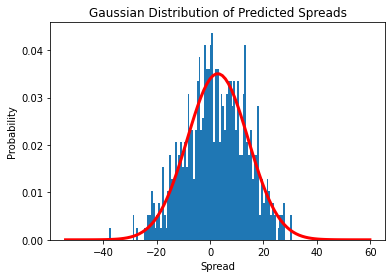

In [90]:
x = np.linspace(avg_spread - 5*sd_spread,  avg_spread + 5*sd_spread, 100)
plt.hist(games_2021["pred_spread"], bins=100, density=True)
plt.plot(x, stats.norm.pdf(x, avg_spread, sd_spread),
       'r', lw=3, label='norm pdf')
plt.title("Gaussian Distribution of Predicted Spreads")
plt.xlabel("Spread")
plt.ylabel("Probability")
# The predicted spread follows some gaussian distribution

In [91]:
# If spread is positive, HOME team is more likely to win and vice versa
def pred_winners(predictions):
    winners = []
    for i in predictions:
        if (i >= 0):
            winners.append(1)
        else:
            winners.append(0)
    return winners

home_wins = pred_winners(y_pred)

In [92]:
games["pred_HOME_TEAM_WINS"] = np.zeros(len(games["spread"]))
games["pred_HOME_TEAM_WINS"] = home_wins
games.head()

GAME_DATE_EST   GAME_ID  ... pred_spread  pred_HOME_TEAM_WINS
0    2014-10-04  11400001  ...   -4.365211                    0
1    2014-10-05  11400002  ...   -5.902613                    0
2    2014-10-06  11400005  ...   11.273304                    1
3    2014-10-06  11400004  ...   -4.584248                    0
4    2014-10-06  11400007  ...   14.047221                    1

[5 rows x 30 columns]

In [93]:
print ("Train Accuracy is", metrics.accuracy_score(games["HOME_TEAM_WINS"], games["pred_HOME_TEAM_WINS"]))
print ("Train Recall is", metrics.recall_score(games["HOME_TEAM_WINS"], games["pred_HOME_TEAM_WINS"]))

Train Accuracy is 0.8357098574085555
Train Recall is 0.8704884715116686


Text(0.5, 1.0, 'Confusion Matrix of Trained Data')

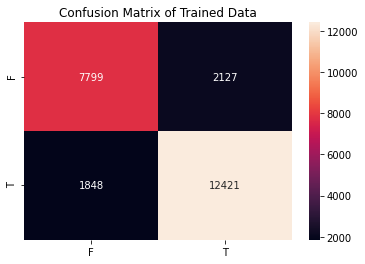

In [94]:
# Confusion Matrix
matrix = confusion_matrix(games["HOME_TEAM_WINS"], games["pred_HOME_TEAM_WINS"])
sns.heatmap(matrix,annot=True, fmt="d", yticklabels=["F", "T"], xticklabels=["F", "T"])
plt.title("Confusion Matrix of Trained Data")

In [95]:
# Cross validation scores
kf = KFold(4, shuffle=True, random_state=0)

cv_scores = cross_val_score(ridge_model_spread,x_train,y_train,cv=kf)
print ("Cross-Validation Accuracies:", cv_scores)
print ("Overall CV score:", np.mean(cv_scores))

Cross-Validation Accuracies: [0.73370755 0.72001532 0.73129451 0.73886614]
Overall CV score: 0.7309708820148203


The mean of the random samples is 0.7310645249645775


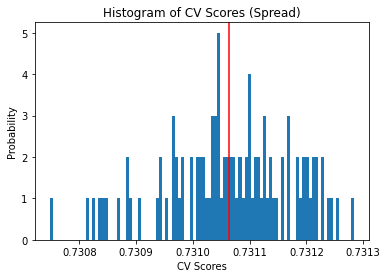

In [96]:
# Creating random samples of CV spread scores
k = 1000
scores = []

for i in range(100):
  kf = KFold(4, shuffle=True)
  cv_scores = cross_val_score(ridge_model_spread,x_train,y_train,cv=kf)
  scores.append(np.mean(cv_scores))

mean = np.mean(scores)
plt.hist(scores, bins=100)
plt.axvline(mean, color='red')
plt.title("Histogram of CV Scores (Spread)")
plt.xlabel("CV Scores")
plt.ylabel("Probability")
print("The mean of the random samples is", mean)

In [97]:
# Testing different alphas for ridge model to optimizing the best alpha
alphas = np.logspace(0, 3, 10)
scores_train = []
scores_cv = []

for i in alphas:
  kf = KFold(4, shuffle=True, random_state=0)
  model = Pipeline([('scaler', StandardScaler()), 
                      ('Ridge', Ridge(alpha=i, fit_intercept=True))])
  train_score = model.fit(x_train, y_train).score(x_train, y_train)
  cv_scores = cross_val_score(model,x_train,y_train,cv=kf)
  scores_cv.append(np.mean(cv_scores))
  scores_train.append(train_score)

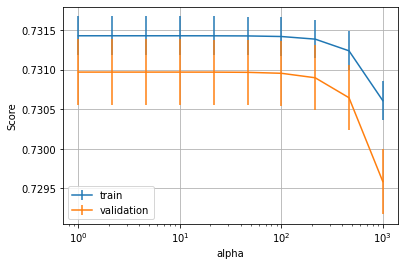

In [98]:
# Helper function from HW
def plot_cv_curve(hyperparm_grid,train_scores,val_scores):
  ax = plt.subplot(111)
  ax.errorbar(hyperparm_grid,train_scores,yerr=np.std(train_scores),label="train")
  ax.errorbar(hyperparm_grid,val_scores,yerr=np.std(val_scores),label="validation")
  ax.set_xlabel('alpha')
  ax.set_ylabel('Score')
  ax.set_xscale('log')
  ax.legend()
  ax.grid()
  return ax
plot_cv_curve(alphas, scores_train, scores_cv)

## Total Points Model

In [99]:
# Predicting total points from 2019
x_test = games[games['SEASON'] == 2019]
x_test.head()

GAME_DATE_EST   GAME_ID  ... pred_spread  pred_HOME_TEAM_WINS
6999    2019-10-04  11900003  ...   -4.780691                    0
7000    2019-10-04  11900002  ...    0.391955                    1
7001    2019-10-05  11900007  ...  -14.489068                    0
7002    2019-10-05  11900006  ...  -13.135887                    0
7003    2019-10-05  11900005  ...   28.203572                    1

[5 rows x 30 columns]

In [100]:
games['total_points'] = games['PTS_home'] + games['PTS_away']
x_test["total_points"] = x_test['PTS_home'] + x_test['PTS_away']
y_train_total = games["total_points"].astype('float')

y_test_total = x_test["total_points"].astype('float')
x_test_total = x_test[[ 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 
                 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']].astype('float')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
y_train_total = y_train_total.fillna(0).values
y_test_total = y_test_total.fillna(0).values

In [102]:
ridge_model_points = Ridge(fit_intercept = True)


ridge_model_points.fit(x_train, y_train_total)
y_pred_total = ridge_model_points.predict(x_train)

games["pred_total"] = np.zeros(len(games["spread"]))
games["pred_total"] = y_pred_total
games.head()

GAME_DATE_EST   GAME_ID  ... total_points  pred_total
0    2014-10-04  11400001  ...        184.0  193.544841
1    2014-10-05  11400002  ...        193.0  191.913533
2    2014-10-06  11400005  ...        193.0  198.516860
3    2014-10-06  11400004  ...        166.0  171.116175
4    2014-10-06  11400007  ...        180.0  188.312561

[5 rows x 32 columns]

In [103]:
ridge_model_points_error = metrics.mean_squared_error(y_train_total, y_pred_total)
ridge_model_points_error

180.93252860366434

Text(0, 0.5, 'Error')

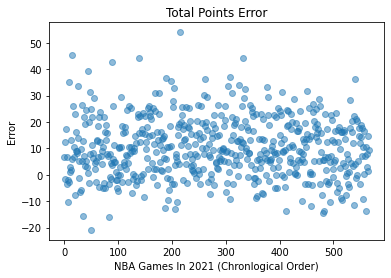

In [104]:
games_2021 = games[games["GAME_DATE_EST"].str.contains("2021")]
x = range(len(games_2021))
y1 = games_2021["total_points"] - games_2021["pred_total"]

plt.scatter(x, y1, alpha=0.5)
plt.title("Total Points Error")
plt.xlabel("NBA Games In 2021 (Chronlogical Order)")
plt.ylabel("Error")

Text(0, 0.5, 'Probability')

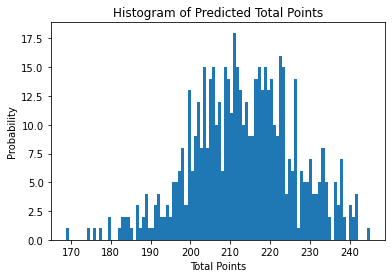

In [105]:
plt.hist(games_2021["pred_total"], bins=100)
plt.title("Histogram of Predicted Total Points")
plt.xlabel("Total Points")
plt.ylabel("Probability")


In [106]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [107]:
print('OSR2:', OSR2(ridge_model_points, x_test_total, y_test_total, y_train_total))

OSR2: 0.6686679677909846


# Simulation

In [108]:
teams_avg_features = pd.DataFrame({"HOME_TEAM_ID": teams["TEAM_ID"], 
                                "ABBREVIATION":teams["ABBREVIATION"], 
                                "NICKNAME_home":teams["CITY"] +  " " + teams["NICKNAME"]})

home_features = ['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']

In [109]:
def initalize_teams():
    teams_avg_features["W_PCT_home"] = teams_avg_features.HOME_TEAM_ID.map(ranking.set_index('TEAM_ID')['W_PCT'].to_dict())

    for f in home_features:
      column = []
      for team in teams_avg_features["ABBREVIATION"]:
        avg = games[games["home_team_abv"] == team][f].mean()
        column.append(avg)
      name = f + "_avg"
      teams_avg_features[name] = np.zeros(len(teams_avg_features["ABBREVIATION"]))
      teams_avg_features[name] = column

initalize_teams()
# Get averages for each of the home features 
# These home features are the inital values for the simulation
teams_avg_features.head()

HOME_TEAM_ID ABBREVIATION  ... AST_home_avg  REB_home_avg
0    1610612737          ATL  ...    23.688050     42.386164
1    1610612738          BOS  ...    23.529825     42.247953
2    1610612740          NOP  ...    23.125974     43.035065
3    1610612741          CHI  ...    22.969475     45.126984
4    1610612742          DAL  ...    22.143207     43.523868

[5 rows x 9 columns]

In [110]:
# Information for each of the features for our ridge model
home_features_avg = ['FG_PCT_home_avg', 'FT_PCT_home_avg', 'FG3_PCT_home_avg', 'AST_home_avg', 'REB_home_avg']
for f in home_features_avg:
  print(f, teams_avg_features[f].describe())

FG_PCT_home_avg count    30.000000
mean      0.459939
std       0.008614
min       0.442985
25%       0.454033
50%       0.459715
75%       0.465031
max       0.479895
Name: FG_PCT_home_avg, dtype: float64
FT_PCT_home_avg count    30.000000
mean      0.758750
std       0.013519
min       0.734290
25%       0.750107
50%       0.758832
75%       0.766497
max       0.787419
Name: FT_PCT_home_avg, dtype: float64
FG3_PCT_home_avg count    30.000000
mean      0.355812
std       0.010576
min       0.341849
25%       0.348450
50%       0.355676
75%       0.359479
max       0.391134
Name: FG3_PCT_home_avg, dtype: float64
AST_home_avg count    30.000000
mean     22.595334
std       1.244525
min      20.260927
25%      21.784705
50%      22.489044
75%      23.443488
max      25.880689
Name: AST_home_avg, dtype: float64
REB_home_avg count    30.000000
mean     43.230377
std       0.793797
min      41.609896
25%      42.718726
50%      43.167875
75%      43.716877
max      45.126984
Name: REB_home_

In [125]:
# Returns a new dataframe containing n simulated games 
def start_simulation(n, alpha,print_text=False, games=[] ,progress=True):
  game_simulation = pd.DataFrame({})
  sym = ["+", "-"]
  
  if (print_text):
    print('\033[1m' + "NBA Predictions" + '\033[0m')
  if len(games) >= 1:
    n = len(games)
  
  if progress:
    progress = widgets.FloatProgress(
      value=0,
      min=0,
      max=n,
      description='Processing:',
      bar_style='info',
      style={'bar_color': '#ff0000'},
      orientation='horizontal'
    )
    display(progress)
    time_start = timer()
  for i in range(n):
    progress.value = i + 1
    if len(games) >= 1:
      home_team = games[i][0]
      away_team = games[i][1]
    else:
      home_team = random.choice(team_abvs)
      away_team = home_team
      while (home_team == away_team):
         away_team = random.choice(team_abvs)
    home_team = teams_avg_features[teams_avg_features['ABBREVIATION'] == home_team].rename(columns={'ABBREVIATION':'home_team_abv'}).reset_index(drop=True)
    away_team = teams_avg_features[teams_avg_features['ABBREVIATION'] == away_team].rename(columns={'ABBREVIATION': 'vis_team_abv', 
                                                                                                    "W_PCT_home": "W_PCT_away",
                                                                                                    'NICKNAME_home': 'NICKNAME_away', 
                                                                                                    "FG_PCT_home_avg": "FG_PCT_away_avg",
                                                                                                    "FT_PCT_home_avg": "FT_PCT_away_avg",
                                                                                                    "FG3_PCT_home_avg":	"FG3_PCT_away_avg",
                                                                                                    "AST_home_avg": "AST_away_avg",
                                                                                                    "REB_home_avg":"REB_away_avg" }).reset_index(drop=True)

    game_teams = [home_team["NICKNAME_home"].item(),away_team["NICKNAME_away"].item()]

    game = pd.concat([home_team, away_team], axis=1, join="inner")

    features = ['FG_PCT_home_avg', 'FT_PCT_home_avg', 'FG3_PCT_home_avg', 'AST_home_avg', 'REB_home_avg', 
                 'FG_PCT_away_avg', 'FT_PCT_away_avg', 'FG3_PCT_away_avg', 'AST_away_avg', 'REB_away_avg']
    x_simulated = game[features].astype('float')

    # Predicing the spread/total points and the winner
    spread = ridge_model_spread.predict(x_simulated)
    tot_points = [np.round(i) for i in ridge_model_points.predict(x_simulated)]
    
    game["spread"] = np.zeros(1)
    game["spread"] = spread

    game["total_points"] = np.zeros(1)
    game["total_points"] = tot_points
    
    home_wins = pred_winners(spread)
    game["HOME_TEAM_WINS"] = np.zeros(1)
    game["HOME_TEAM_WINS"] = home_wins

    # Updating features based on the winner
    
    home_perf_change = []
    away_perf_change = []
    for f in features:
      if "home" in f:
        # If home wins, the performance of the home team will increase and the performance for the away team will decrease.
        # alpha is the scalar value for each increase/decrease
          if sym[1 - game["HOME_TEAM_WINS"].item()] == "+":
            inc = np.round((alpha*np.std(teams_avg_features[f])), 6)
            dec = np.round(-(alpha*np.std(teams_avg_features[f])), 6)
            home_perf_change.append(inc)
            away_perf_change.append(dec)
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[0], f] += inc
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[1], f] += dec
          else:
            dec = np.round(-(alpha*np.std(teams_avg_features[f])), 6)
            inc = np.round((alpha*np.std(teams_avg_features[f])), 6)
            home_perf_change.append(dec)
            away_perf_change.append(inc)
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[0], f] += dec
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[1], f] += inc
    
    game["home_perf_change"] = np.zeros(1)
    game["home_perf_change"] = [home_perf_change]

    game["away_perf_change"] = np.zeros(1)
    game["away_perf_change"] = [away_perf_change]

    if (len(game_simulation) >= 1):
      game_simulation = game_simulation.append(game.iloc[0])
    else: 
      game_simulation = pd.concat([game_simulation, game], axis=1)


# Printing values for debugging
    if (print_text):
      print()
      print("Game", i+1, ":", game_teams[0], "vs", game_teams[1])

      print('\033[1m' + "Spread" + '\033[0m', ":", np.round(spread[0], 3))
      print(game_teams[1 - game["HOME_TEAM_WINS"].item()], "won the game.")

      print(game_teams[0], "Performance:", home_perf_change)
      print(game_teams[1], " Performance:", away_perf_change)


  game_simulation = game_simulation.reset_index(drop=True)
  if progress:
    time_end = timer()
    print("Elapsed Time: {0} second".format(time_end-time_start))
  progress.layout.display = 'none'
  return game_simulation

In [126]:
# Example simulation for debugging
start_simulation(3,  0.05, print_text=True)

NBA Predictions


FloatProgress(value=0.0, bar_style='info', description='Processing:', max=3.0, style=ProgressStyle(bar_color='…


Game 1 : Golden State Warriors vs Charlotte Hornets
Spread : 6.169
Golden State Warriors won the game.
Golden State Warriors Performance: [0.000427, 0.000667, 0.000523, 0.061336, 0.038931]
Charlotte Hornets  Performance: [-0.000427, -0.000667, -0.000523, -0.061336, -0.038931]

Game 2 : Washington Wizards vs Golden State Warriors
Spread : -2.957
Golden State Warriors won the game.
Washington Wizards Performance: [-0.00043, -0.000668, -0.000525, -0.061654, -0.039069]
Golden State Warriors  Performance: [0.00043, 0.000668, 0.000525, 0.061654, 0.039069]

Game 3 : Utah Jazz vs Denver Nuggets
Spread : -0.639
Denver Nuggets won the game.
Utah Jazz Performance: [-0.000431, -0.000669, -0.000527, -0.061968, -0.039177]
Denver Nuggets  Performance: [0.000431, 0.000669, 0.000527, 0.061968, 0.039177]
Elapsed Time: 0.14056859199990868 second


HOME_TEAM_ID  ...                                   away_perf_change
0    1610612744  ...  [-0.000427, -0.000667, -0.000523, -0.061336, -...
1    1610612764  ...  [0.00043, 0.000668, 0.000525, 0.061654, 0.039069]
2    1610612762  ...  [0.000431, 0.000669, 0.000527, 0.061968, 0.039...

[3 rows x 23 columns]

# Helper Functions

In [133]:
def create_tabs(df):
  teams_ = df["NICKNAME_home"].unique()
  tabs = []
  
  for t in teams_:
    text = []
    tab_widget = []
    team = df[df["NICKNAME_home"] == t]
    features = ['FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB']

    info_accordion_text = "<b>ℹ Each tab contains all games where " + team.iloc[0]["NICKNAME_home"] + " is the home team." + "<br>" + \
    "ℹ FG_PCT = Field Goal Percentage | FT_PCT = Free Throw Percentage | FG3_PCT = Field Goal (3 Points) Percentage | AST = Assist | REB = Rebounds</b>"
    tab_widget.append(widgets.HTML(value=info_accordion_text,disabled=False))

    for i in range(len(team)):
      team_text = "Home: " + team.iloc[i]["NICKNAME_home"] + " | " + "Away: " + team.iloc[i]["NICKNAME_away"] + "<br>" + \
      "<b>Total Points:</b> " + str(team.iloc[i]["total_points"]) + "<br>" + \
      "<b>Projected Winner:</b> " + [team.iloc[i]["NICKNAME_away"], team.iloc[i]["NICKNAME_home"]][team.iloc[i]["HOME_TEAM_WINS"]] + "<br>" + \
      "<b>Spread:</b> " + str(team.iloc[i]["spread"]) + "<br>" + \
      "<u>" + team.iloc[i]["NICKNAME_home"] + "</u>" + "</u><br>" + \
      " ".join([features[i-1]  + ": " + ("+" + str(value)).replace("+-", "-") + " |" for i, value in enumerate(team.iloc[i]["home_perf_change"])]) + "<br>" + \
      "<u>" + team.iloc[i]["NICKNAME_away"] + "</u>" + "</u><br>" + \
      " ".join([features[i-1]  + ": " + ("+" + str(value)).replace("+-", "-") + " |" for i, value in enumerate(team.iloc[i]["away_perf_change"])])

      text_widget = widgets.HTML(value=team_text,disabled=False)
      widget = widgets.Accordion(children=[text_widget], selected_index=None)
      widget.set_title(0, "Game " + str(i+1))
      tab_widget.append(widget)
    tabs.append(tab_widget)

  return tabs

def click(button):
    value = button.owner.value
    if value == "1 NBA Game":
      select_home.layout.display = "block"
      select_away.layout.display = "block"
      n_slider.layout.display = "none"
      description.value = "<b>ℹ Selects 2 teams to set as the home team and away team" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns 1 simulated game</b>"
    elif value == "Random Simulation":
      select_home.layout.display = "none"
      select_away.layout.display = "none"
      n_slider.layout.display = "block"
      description.value = "<b>ℹ Runs a random simuation where for each game, two random teams are choosen to play agaisnt each other." + "<br>" + \
"# of Games: The number of NBA games to simulate. Default: 10" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns n simulated games</b>"
    elif value == "2018-19 Season":
      select_home.layout.display = "none"
      select_away.layout.display = "none"
      n_slider.layout.display = "none"
      description.value = "<b>ℹ Simulates games from the 2018-2019 season schedule in the NBA dataset" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns simulated games from the 2018-19 season (takes a while to process).</b>"
    elif value == "2020-21 Season (May)":
      select_home.layout.display = "none"
      select_away.layout.display = "none"
      n_slider.layout.display = "none"
      description.value = "<b>ℹ Simulates games from the May 2021 NBA season schedule" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns simulated games from the 2018-19 season.</b>"

def clear_results(button):
    clear_output()
    display(title,select,widgets.HBox([select_home, select_away]),n_slider,alpha_float, widgets.HBox([start, clear_button]))

# Datasets

In [134]:
# 2018-19 Schedule from NBA dataset
teams_1819 = []
games_1819 = games[(games['GAME_DATE_EST'] >= '2018-10-16') & (games['GAME_DATE_EST'] <= '2019-06-30')]
home_teams = (games_1819["home_team_abv"]).values
vis_teams = (games_1819["vis_team_abv"]).values
for i in range(len(home_teams)):
  teams_1819.append([home_teams[i], vis_teams[i]])
teams_1819[:5]
# Aggreating the data into the right form for the simulation

[['GSW', 'OKC'],
 ['BOS', 'PHI'],
 ['PHX', 'DAL'],
 ['LAC', 'DEN'],
 ['SAC', 'UTA']]

In [135]:
# May 2021 Schedule from NBA 
# Source: https://www.basketball-reference.com/leagues/NBA_2021_games-may.html

games_21 = pd.read_csv('nba_games_may2021.csv')
games_21["home_team_abv"] = games_21["Home/Neutral"].map(teams_avg_features.set_index('NICKNAME_home')['ABBREVIATION'].to_dict())
games_21["vis_team_abv"] = games_21["Visitor/Neutral"].map(teams_avg_features.set_index('NICKNAME_home')['ABBREVIATION'].to_dict())

teams_21 = []
home_teams_21 = (games_21["home_team_abv"]).values
vis_teams_21 = (games_21["vis_team_abv"]).values
for i in range(len(home_teams_21)):
  teams_21.append([home_teams_21[i], vis_teams_21[i]])
teams_21[:5]
# Aggreating the data into the right form for the simulation

[['CHA', 'DET'],
 ['HOU', 'GSW'],
 ['ATL', 'CHI'],
 ['CLE', 'MIA'],
 ['MIN', 'NOP']]

# **UI**

In [136]:
title_text = "<big>" + "NBA Spread & Winner Predictor" + "</big>"
title = widgets.HTML(value=title_text,disabled=False)

description_text = "<b>ℹ Selects 2 teams to set as the home team and away team" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns 1 simulated game</b>"
description = widgets.HTML(value=description_text,disabled=False)

select_home = widgets.Select(
    options=teams_avg_features["NICKNAME_home"].values,
    value=teams_avg_features["NICKNAME_home"].values[0],
    description='Home Team:',
    disabled=False
)
select_away = widgets.Select(
    options=teams_avg_features["NICKNAME_home"].values,
    value=teams_avg_features["NICKNAME_home"].values[0],
    description='Away Team:',
    disabled=False
)
n_slider = widgets.BoundedIntText(
    value=10,
    min=1,
    max=1000,
    step=1,
    description='# of Games:',
    disabled=False
)
n_slider.layout.display = "none"

alpha_float = widgets.BoundedFloatText(
    value=0.05,
    min=0,
    max=2,
    step=0.01,
    description="Alpha:",
    disabled=False
)

select = widgets.ToggleButtons(
    options=['1 NBA Game', 'Random Simulation', "2018-19 Season", "2020-21 Season (May)"],
    description='Options:',
    disabled=False,
    button_style='', 
    tooltip='Description',
)

start = widgets.Button(
    value=False,
    description='Start Simulation',
    disabled=False,
    button_style='',
    tooltip='Description',
    icon='check'
)

clear_button = widgets.Button(
    value=False,
    description='Clear Results',
    disabled=False,
    button_style='', 
    tooltip='Clear the results of all tabs',
    icon='check'
)
clear_button.on_click(clear_results)

tab = widgets.Tab(children=[])
tab.layout.display = 'none'

def start_sim(button):
    value = select.value
    if value == "1 NBA Game":
      alpha = alpha_float.value
      
      initalize_teams()
      team_1 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_home.value]["ABBREVIATION"].values[0]
      team_2 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_away.value]["ABBREVIATION"].values[0]
      teams_select = [[team_1, team_2]]

      n = len(teams_select)
      df = start_simulation(0, alpha, print_text=False, games=teams_select)
    elif value == "Random Simulation":
      n = n_slider.value
      alpha = alpha_float.value

      initalize_teams()
      df = start_simulation(n,  alpha, print_text=False, games=[])
    elif value == "2018-19 Season":
      alpha = alpha_float.value
      
      
      initalize_teams()
      team_1 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_home.value]["ABBREVIATION"].values[0]
      team_2 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_away.value]["ABBREVIATION"].values[0]
      teams_select = teams_1819

      n = len(teams_select)
      df = start_simulation(0,  alpha, print_text=False, games=teams_select)

    elif value == "2020-21 Season (May)":
      alpha = alpha_float.value
     
      
      initalize_teams()
      team_1 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_home.value]["ABBREVIATION"].values[0]
      team_2 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_away.value]["ABBREVIATION"].values[0]
      teams_select = teams_21

      n = len(teams_select)
      df = start_simulation(0,  alpha, print_text=False, games=teams_select)

    children = []
    games_tabs = create_tabs(df)
    
    %matplotlib inline
    df_plot = df.groupby(['NICKNAME_home']).mean()

    def winning_per_graph():
        plt.figure(figsize=[13,7])
        x = df_plot.index.values
        y = df_plot["HOME_TEAM_WINS"].values
        plt.barh(x, y, height=0.5)
        
        plt.rcParams['font.size'] = '13'
        plt.title("Winning Percentage of Home Teams")
        plt.xlabel("Winning Percentage")
        plt.tight_layout()
        plt.show()

    interactive_plot = interactive(winning_per_graph)
    output = interactive_plot.children[-1]
    output.layout.height = '500px'
    def setup_graph(df):

      out = widgets.Output()
      with out:
          display(df)
      return out

    df_wp = df_plot[["HOME_TEAM_WINS", "spread"]].rename(columns={"HOME_TEAM_WINS": "Avg WP", "spread": " Avg Spread"}).sort_values("Avg WP", ascending=False)
    df_wp.index.name = 'Home Teams'
    widget = setup_graph(df_wp)

    children.append(widgets.HBox([widget, interactive_plot]))
    for i in range(len(games_tabs)):
        children.append(widgets.VBox(games_tabs[i]))
  
    tab = widgets.Tab(children=children)
    li = enumerate(np.insert(df["home_team_abv"].unique(), 0, "Summary"))
    [tab.set_title(i, name) for i, name in li]
    display(tab)

start.on_click(start_sim)
select.observe(click)

display(title,
        select,
        description,
        widgets.HBox([select_home, select_away]),
        n_slider,
        alpha_float, 
        widgets.HBox([start, clear_button]),)

HTML(value='<big>NBA Spread & Winner Predictor</big>')

ToggleButtons(description='Options:', options=('1 NBA Game', 'Random Simulation', '2018-19 Season', '2020-21 S…

BoundedIntText(value=10, description='# of Games:', layout=Layout(display='none'), max=1000, min=1)

BoundedFloatText(value=0.05, description='Alpha:', max=2.0, step=0.01)

FloatProgress(value=0.0, bar_style='info', description='Processing:', max=1312.0, style=ProgressStyle(bar_colo…

Elapsed Time: 53.73480966600073 second
